In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "double"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [2]:
errors = []
cl_estimate = []
angles = []
num = 4
angles = np.arange(num)/num*2*np.pi + np.pi/4

sigma_abs = 4
sigma_vals_cl = sigma_abs*(np.cos(angles) + 1j*np.sin(angles))

ineraction = 2


In [3]:
import numpy as np
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm

data = []

for idx, (angle, sigma) in enumerate(zip(angles, tqdm(sigma_vals_cl))):
    config = Config(dt = 5e-2, trajs = int(1e5), dims = [1], mass_real = sigma, interaction = 2, ada_step = True)
    sim = ComplexLangevinSimulation(config)
    
    sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_param={'order': 1}, langevin_history=True, thermal_time=3, auto_corr=0.1)

    for _ in (range(int(1e3))):
        sim.step()
        for name, tr in sim.trackers.items():
            tr.mark_equilibrated_trajs()
            tr.compute()
    sim.finish()


    data.append(sim.trackers['1_moment'].history.flatten())


Using double precision
Using C^1
Using Numba


 75%|███████▌  | 3/4 [00:09<00:03,  3.07s/it]


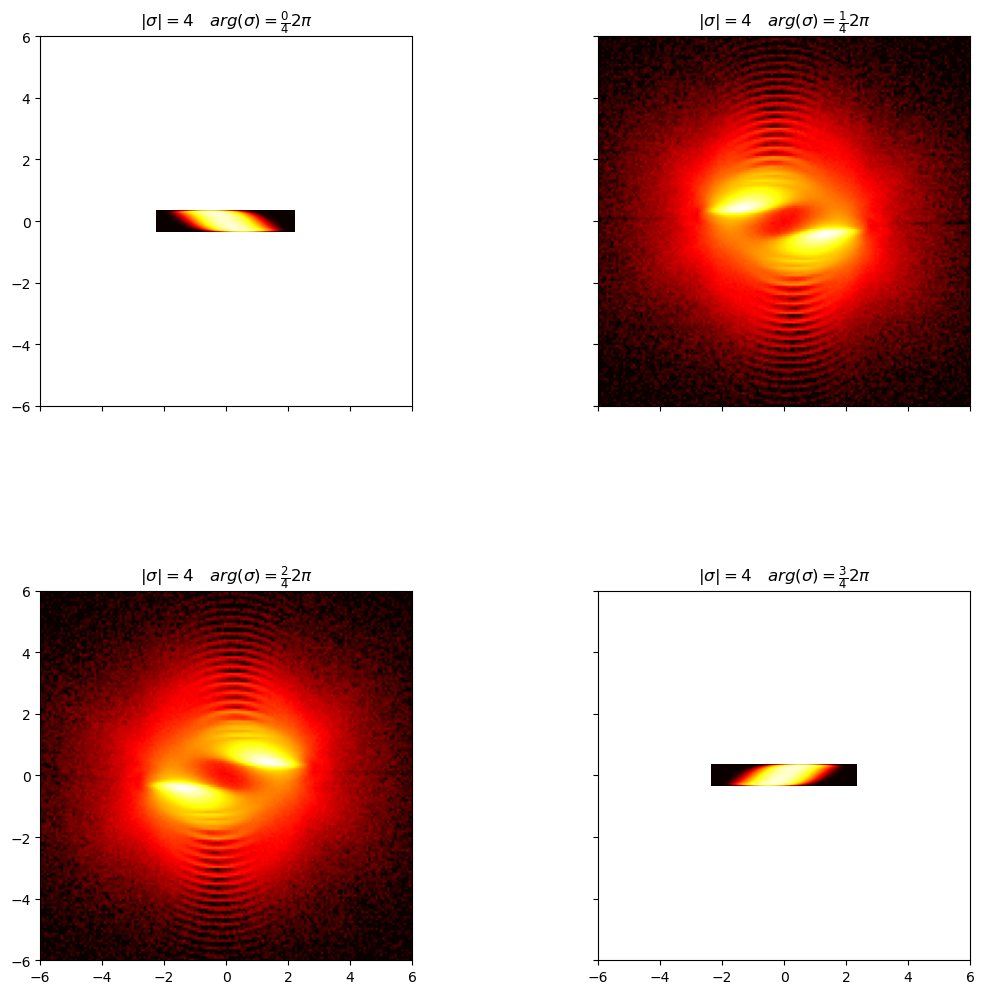

In [4]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(int(np.sqrt(num)), int(np.sqrt(num)), figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

for idx, da in enumerate(data):
    
    magnitudes = np.abs(da)
    da = da[magnitudes <= 20]   
    art_dp = 10+10j
    # da = np.append([art_dp, -art_dp], da)
    real_parts, imag_parts = da.real, da.imag
    bins = 500
    heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

    ax = axes[idx]
    # Plot the heatmap
    ax.imshow(
        np.log10(heatmap+1).T,
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        origin='lower',
        cmap='hot',
        aspect='auto',
    )
    label = rf"$|\sigma|={{{sigma_abs}}} \quad arg(\sigma) = \frac{{{idx}}}{{{num}}} 2\pi$"

    ax.set_title(label)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
plt.show()

100%|██████████| 34/34 [00:00<00:00, 23482.02it/s]


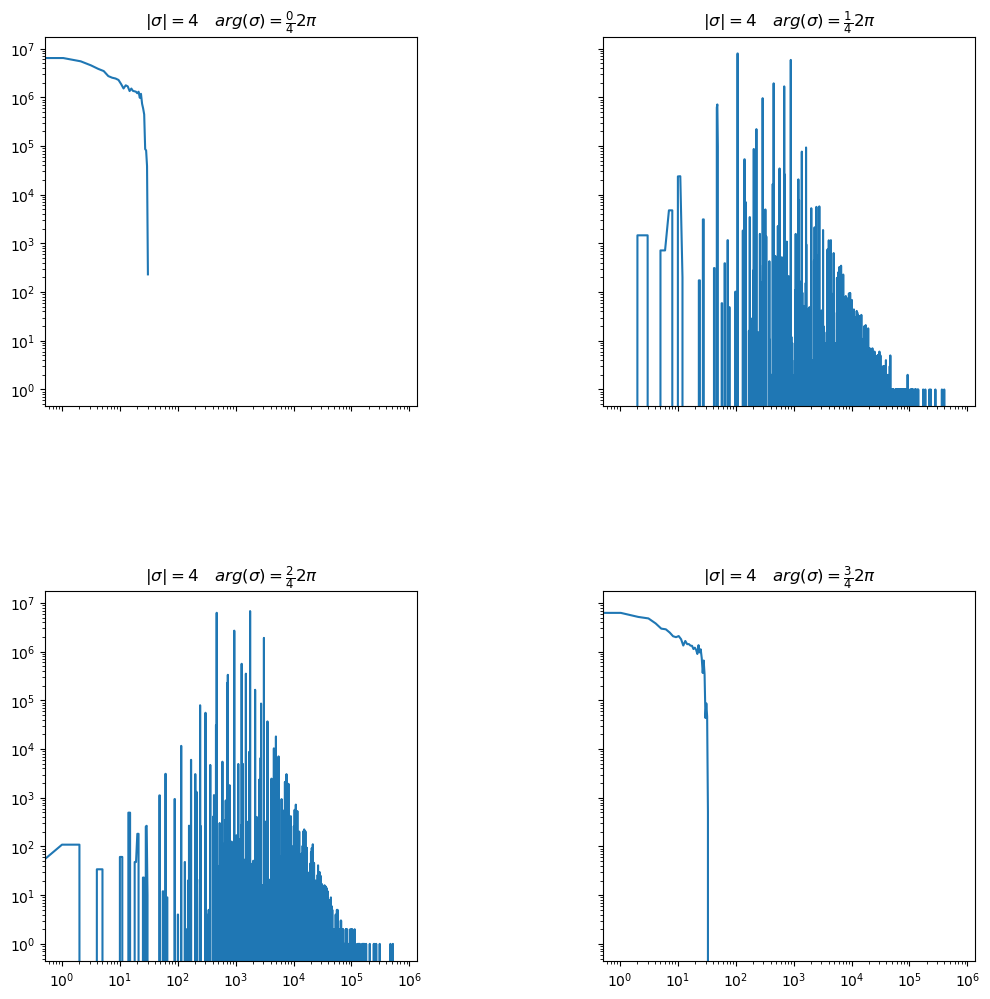

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def abs_drift(z, mass, interaction):
    dr = mass * z + interaction * z * z * z
    return np.abs(dr)  # Example: f(x + iy) = |x + iy|^2 = x^2 + y^2


fig, axes = plt.subplots(int(np.sqrt(num)), int(np.sqrt(num)), figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

for idx, da in enumerate(data):
    ax = axes[idx]
    magnitudes = np.abs(da)
    # da = np.append([art_dp, -art_dp], da)
    real_parts, imag_parts = da.real, da.imag
    bins = 50
    heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    Z = X + 1j * Y  # Complex grid
    
    F_values = abs_drift(Z, mass=sigma, interaction=sim.interaction)

    # Create an array of counts for the specified u_values
    u_values = np.linspace(0, F_values.max(), int(F_values.max()))

    counts = []

    # Vectorized approach: loop over each u_val
    for u_val in tqdm(u_values):
        mask = np.abs(F_values - u_val) < 1
        masked_values = heatmap[mask]
        count = np.sum(masked_values)
        counts.append(count)
        
    ax.plot(u_values, counts)
    ax.set_yscale('log')   
    ax.set_xscale('log')   

    label = rf"$|\sigma|={{{sigma_abs}}} \quad arg(\sigma) = \frac{{{idx}}}{{{num}}} 2\pi$"
    ax.set_title(label)
plt.show()

In [6]:
u_values.max()

34.061206842451995

In [7]:
# Step 6: Define your real-valued function f(x + iy)
def abs_drift(z, mass, interaction):
    dr = mass * z + interaction * z * z * z
    return np.abs(dr)  # Example: f(x + iy) = |x + iy|^2 = x^2 + y^2

# Step 7: Compute f(x + iy) on the histogram grid
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(x_centers, y_centers)
Z = X + 1j * Y  # Complex grid
F_values = abs_drift(Z, mass=sigma, interaction=sim.interaction)

# Step 8: Compute u(z) by mapping f(x + iy) results to bins (if needed)
# For example, aggregate P(x, y) weighted by bins in the z-space.


In [8]:
F_values.max()

34.061206842451995

In [9]:
import numpy as np
from tqdm import tqdm

# Assuming F_values and P are your 2D arrays
# Example placeholder arrays (adjust according to your actual data)
# Define tolerance
tolerance = 0.01

# Create an array of counts for the specified u_values
u_values = np.linspace(0, 50, 50)

counts = []

# Vectorized approach: loop over each u_val
for u_val in tqdm(u_values):
    mask = np.abs(F_values - u_val) < 0.1
    masked_values = heatmap[mask]
    count = np.sum(masked_values)
    counts.append(count)

# `counts` now holds the summed values for each u_val
counts

100%|██████████| 50/50 [00:00<00:00, 25757.21it/s]


[0.0,
 786634.0,
 49100.0,
 143469.0,
 485314.0,
 217773.0,
 342406.0,
 362780.0,
 334972.0,
 218107.0,
 34076.0,
 208145.0,
 219126.0,
 12239.0,
 218235.0,
 109528.0,
 193672.0,
 159917.0,
 213267.0,
 81911.0,
 232126.0,
 75.0,
 59142.0,
 12809.0,
 188176.0,
 239053.0,
 23.0,
 126087.0,
 116234.0,
 1.0,
 16429.0,
 19255.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

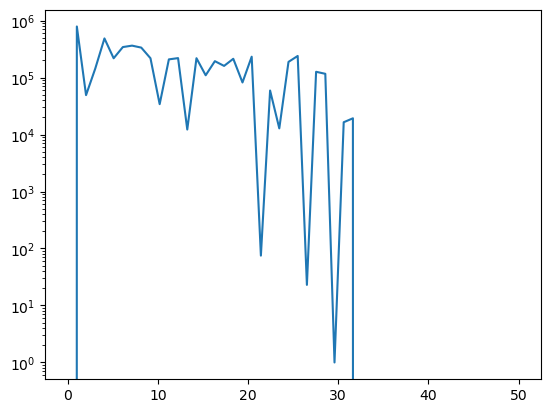

In [10]:
plt.plot(u_values, counts)
plt.yscale('log')